In [1]:
import sys 
sys.path.append("./pocomc/")

import os
import time
import pickle
import roadrunner as rr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import qmc
from multiprocessing import Pool

import pocomc as pc

SEED = 1
np.random.seed(seed=SEED)

n_cpus = os.cpu_count() 
print('This machine has {} CPUs'.format(n_cpus))

This machine has 10 CPUs


In [49]:
class Model:
    def __init__(self, opts): #initial settings
        for key in opts: #loops for all labels in the list 'key'
            setattr(self, key, opts[key]) #creates a dictionary where 'key' are the list of labels & 'ops[key]' are the values
        # Default model output to times and experimental observables
        self.observables= list(self.data.columns)[1:]
        self.defaultOutput= ['time'] + self.observables
        self.n_params= len(self.params)
        self.n_obs= len(self.observables)

    def __call__(self, theta_new):
        theta_new = theta_new
        res = self.log_likelihood(theta_new)
        return res
    
    def run(self, params=None, x0=None, times=None, output=None):
        rr = self.rr
        rr.reset()
        rr.integrator.absolute_tolerance = 1e-12
        rr.integrator.relative_tolerance = 1e-12
        addZero=False

        # Use timepoints of data as default times at which to get sim output
        if params is None:
            params= self.p_true  
        if x0 is None:
            x0= self.x0
        if times is None:
            times= list(self.data['time'].values)
        # make sure zero is first time point
        if (times[0]>0.0):
            addZero= True
            times= [0] + times

        # Set default output are the column names of the data
        if output is None:
            output= self.defaultOutput
       
        # Set parameter values
        for name, value in zip(self.params, params):
            rr[name] = float(value)
        #rr.reset() # force update of parameter expression (POSSIBLY NOT NEEDED)

        # NOTE: If you want to vary the initial conditions, do this by defining a parameter in the model that sets the initial concentration of species and then include this parameter in your list of parameters to fit. 

        # Run trajectories
        try:
            traj = rr.simulate(times=times,selections=output)  
        except:
            # If integration fails return empty array
            return([])

        if (addZero):
            # Return traj with zero timepoint removed
            return(traj[1:,:])
        else:
            return(traj)
        
    def log_prior(self, theta_new): 
        bools = [(low <= i <= high) for i,low,high in zip(theta_new, self.lower_bnds, self.upper_bnds)] #if generated values are within bounds
        all_in_range = np.all(bools) #if all values are true, then output is true
        if all_in_range: 
            return 0.0 
        return -np.inf #if even one parameter out of bounds, it's false, and returns -infinity

    def log_likelihood(self, theta_new): #how good is this candidate parameter fitting my data (maximize it)
        params = theta_new[:self.n_params] 
        if self.fit_x0: 
            x0 = theta_new[self.n_params:(self.n_params + len(self.x_0))] #sets x0 to 'theta_true' x0 values
        else:
            x0 = self.x0
        y = self.run(params=params, x0=x0)[:,1:] #sets y to the y results of solving ODE
        if (len(y)==0):
            # return large (but not infinite value) if integration fails
            return(-1e11)
        if (np.any(np.isnan(y))):
            return(-1e12)

        if self.fit_sigma:
            sigma = theta_new[-len(self.observables):] #observable index related to sigma
        else:
            sigma = [1] * len(self.observables) #makes all sigmas default to 1

        obs = self.data.values[:,1:] #sets data

        # Calculate likelihood
        #term1 = 0 #-0.5 * np.log(2*np.pi*np.square(sigma))
        #term2 = sum (y-obsnp.square(np.subtract(y, obs)) / (2*np.square(sigma))
        #logLH = np.sum(term1 - term2)
        ll= -sum(((y-obs)/(sigma))**2)# chi^2
        return(ll[0])

In [50]:
mod_opts = {} 
# load data for model
mod_df = pd.read_csv('p1.csv', header=0, delimiter=",") #reads in data file
mod_opts['data'] = mod_df
# Load in SBML model using libroadrunner
sbml_file = "SVM_sbml.xml"
mod_opts['rr'] = rr.RoadRunner(sbml_file)
mod_opts['params'] = ["log_beta", "log_delta", "log_pi"]
mod_opts["species"] = ["S1", "S2", "S3"]
mod_opts['x0'] = [1e7,1,6.67] # initial conditions (if given)

# ! TO DO: we currently assume it fit_x0, then ALL species initial conditions are fit
mod_opts['fit_x0'] = False # fit initial conditions?
mod_opts['fit_sigma'] = False #fit sigma?
mod_opts['p_true'] = [-7.0, 0.0, 2.0] #guess param values(in log)
mod_opts['lower_bnds'] = [-9.0,-1.0,0.0] #lower bounds(in log)
mod_opts['upper_bnds'] = [-5.0,1.0,3.0] #upper bounds(in log)

model = Model(mod_opts)

In [51]:
model.rr['log_pi']=0
model.rr.reset()
print(np.log10(model.rr['init(S3)']))
print(np.log10(model.rr['V0']))

0.8241258339165489
0.8241258339165489


0.8241258339165488
0.84852062
0.8241258339165489
0.8241258339165489


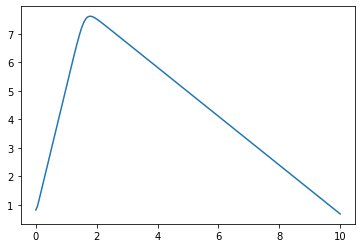

In [48]:
traj= model.run(params=[-6.53916286,  0.29444396,  2.02461192],times=np.linspace(0,10,201))
plt.plot(traj[:,0],traj[:,1])
print(traj[0,1])
print(model.rr['log_pi']-model.rr['log_gamma'])
#model.rr.reset()
print(np.log10(model.rr['V0']))
print(np.log10(model.rr['init(S3)']))

In [52]:
def plot_fit(p):
    traj= model.run(params=p,times=np.linspace(0,10,201))
    plt.plot(model.data['time'].values,model.data['log10_V'].values,'go',label='data')
    plt.plot(traj[:,0],traj[:,1],'g-',label='fit')
    cost= model.log_likelihood(p)
    plt.title(f'Fit for $\chi^2=${-cost:0.2e}')
    _=plt.legend()

In [53]:
from scipy.optimize import minimize, fsolve
chisq= lambda p: -model.log_likelihood(p)
bf = minimize(chisq, x0=[-7,-1,1], method='nelder-mead',options={'maxiter':1000})
print(bf)

 final_simplex: (array([[-6.53916286,  0.29444396,  2.02461192],
       [-6.53909244,  0.29443456,  2.0245681 ],
       [-6.53918518,  0.29444182,  2.02466087],
       [-6.53912817,  0.29444778,  2.02460305]]), array([0.18155251, 0.18155252, 0.18155252, 0.18155257]))
           fun: 0.1815525073557192
       message: 'Optimization terminated successfully.'
          nfev: 951
           nit: 551
        status: 0
       success: True
             x: array([-6.53916286,  0.29444396,  2.02461192])


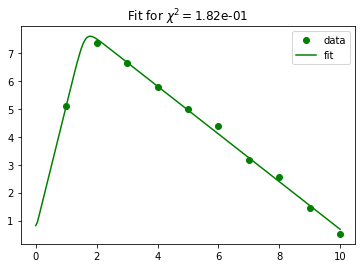

In [54]:
plot_fit(bf.x)

In [44]:
n_particles = 1000
# Initialise particles' positions using samples from the prior 
sampler = qmc.LatinHypercube(d=model.n_params, seed=SEED)
sample = sampler.random(n=n_particles) 
print("The discrepancy of the sampling (i.e., sample quality): %.4f"%qmc.discrepancy(sample)) #discrepancy is distance between cont. uniform distr. on hypercube & discr. uniform distr. on n distinct sample points
prior_samples = qmc.scale(sample, l_bounds=model.lower_bnds, u_bounds=model.upper_bnds)
print(prior_samples.shape)

The discrepancy of the sampling (i.e., sample quality): 0.0001
(1000, 3)


In [45]:
t0 = time.time() #stores current time, date, year, etc. in one float
# with Pool(n_cpus) as pool: #sets up code to run over my n number of cpus on laptop
    
sampler = pc.Sampler(n_particles = n_particles,
                n_dim = model.n_params,
                log_likelihood = model.log_likelihood,
                log_prior = model.log_prior,
                bounds = np.array(list(zip(model.lower_bnds, model.upper_bnds))),
                random_state=SEED,
                vectorize_likelihood=False,
                vectorize_prior=False,
                infer_vectorization=False
            ) #stores all relevant info from # of parameters being fit (ndim) to the actual results

sampler.run(prior_samples = prior_samples) #starts with prior sample definied in latin hypercube sampling, and runs it
result = sampler.results #results of sampler.run on prior_samples

with open('tester01_result.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL) #saves result object (dictionary) to pickle file

# we need to remove the librr simulator from the class in order to successfully save and load the class from a pkl file. 
#del model.rr
with open('tester01_mod.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(model.__dict__, f, protocol=pickle.HIGHEST_PROTOCOL) #saves model dictionary in pickle file

t1 = time.time() #time after running this section
seconds = t1-t0 #difference in start and stop time

elapsed = time.strftime("%H:%M:%S", time.gmtime(seconds)) #converts float to a time quantity we use
print('\nElapsed time: ', elapsed) #printing time it took for code to run

Iter: 15it [01:52,  8.53s/it, beta=0.0809, calls=37000, ESS=0.949, logZ=-3.76, accept=0.261, N=1, scale=1.05, corr=0.824]/Users/faeder/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 16it [01:59,  8.63s/it, beta=0.106, calls=37999, ESS=0.949, logZ=-4.1, accept=0.281, N=2, scale=1.06, corr=0.682]  /Users/faeder/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2094: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 27it [03:37,  8.07s/it, beta=1, calls=61953, ESS=0.969, logZ=-7.71, accept=0.255, N=2, scale=1.12, corr=0.697]    


Elapsed time:  00:03:43


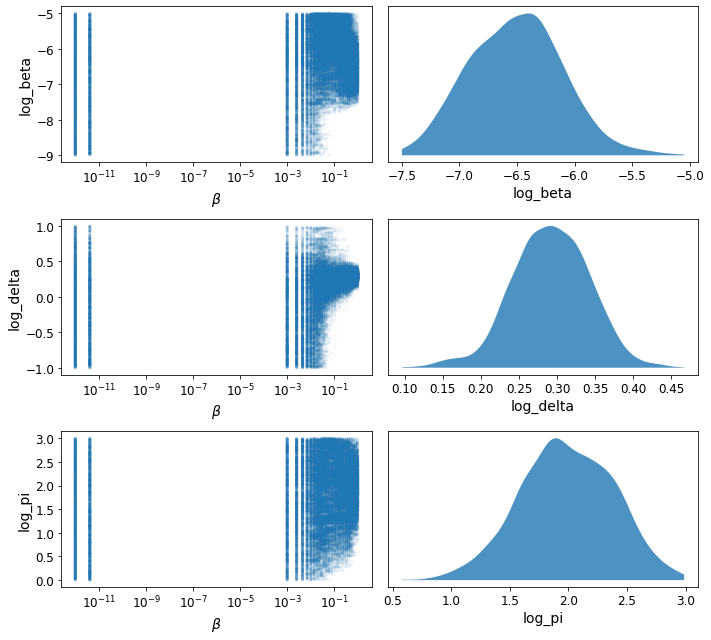

In [46]:
pc.plotting.trace(result, labels=model.params);